### Linear Regression

* In this section, linear regression will be utilized to **predict** the **LogP** value. 


* Additionally, we will explore how the inclusion of **polynomial and rational difference features** can enhance the model's performance. One of the goals of this study is to compare how well different models (linear regression, random forest, neural networks) manage with reproducing those features.


* The model's performance will also be refined through **regularization** and **feature selection**.


* At the end, a summary of the model's performance at different levels of complexity will be provided.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modules for data preprocessing and feature engineering
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression, mutual_info_regression

# modules for model selection and evaluation
from sklearn.model_selection import KFold, cross_validate, GridSearchCV  
from sklearn.metrics import mean_squared_error, r2_score

# modules for building the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# saving sklearn models
import joblib

### Dataset

To begin, we will import the train-validation and test sets. In the test set, 20% of the original dataset is kept for the final evaluation of the model's performance and for making comparisons between various models.

In [2]:
# import training-validation set and test set
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [206]:
# separate the datasets into features and the target variables
X = df_train.drop('logp', axis=1)
y = df_train['logp']

X_test = df_test.drop('logp', axis=1)
y_test = df_test['logp']

In [4]:
print(f'The size of the \033[1mtrain set\033[0m is: \033[1m{len(X)}\033[0m and the size of the \033[1mtest set\033[0m is: \033[1m{len(X_test)}\033[0m')

The size of the train set is: 49094 and the size of the test set is: 12274


In [5]:
# list of original features
original_features = ['mwt', 'rings', 'heavy_atoms', 'hetero_atoms', 'fraction_sp3',
       'charge1', 'Hbond_donors1', 'Hbond_acceptors1', 'rotatable_bonds1',
       'apolar_des1', 'polar_des1', 'RDtpsa', 'RDCfraction']

### 1. Baseline Linear Regression Model 

To establish a baseline for tracking changes in the model's performance, especially as a result of adding engineered features, we'll start with a basic model that uses only the original features and doesn't include any transformers. 


Also, in this part functions used in this study will be defined.

In [6]:
# linear model
lr_model = LinearRegression()

The size of each fold used in cross-validation throughout this study will be approximately 5000 samples.

In [7]:
# dividing the training-validation dataset into 10 folds
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In this study, **GridSearchCV** was used for hyperparameter optimization and evaluating models' performance. The **scoring** methods chosen for this purpose were **Mean Squared Error (MSE) and R-squared (R²)**. The best model will be selected based on the MSE score.

In [8]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'R-squared': 'r2'
}

To evaluate the current model, using cross_validate would be sufficient for determining the mean performance along with its standard deviation, as there are no hyperparameters to tune at this stage. However, for the sake of maintaining a consistent output format throughout the study, let's use GridSearchCV here.

In [9]:
grid_basic = GridSearchCV(lr_model, param_grid={}, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True).fit(X[original_features], y)

Let's define a function which will **extract and assign specific performance metrics** (R-squared and Mean Squared Error) from the **results of a cross-validation** grid search. This function will focus on the mean scores for both the training and testing sets, along with their respective standard deviations.

In [10]:
def get_best_scores(grid, r):
    """
    the function extracts and assigns specific performance metrics (mean and std of MSE and R2)
    based on GridSearchCV results (data in the r-th row)
    """
    global CV_train_R2, CV_train_R2_std, CV_test_R2, CV_test_R2_std, CV_train_MSE, CV_train_MSE_std, CV_test_MSE, CV_test_MSE_std
    
    results = grid.cv_results_
    
    CV_train_R2 = results['mean_train_R-squared'][r]
    CV_train_R2_std = results['std_train_R-squared'][r]
    CV_test_R2 = results['mean_test_R-squared'][r]
    CV_test_R2_std = results['std_test_R-squared'][r]
    CV_train_MSE = results['mean_train_MSE'][r]
    CV_train_MSE_std = results['std_train_MSE'][r]
    CV_test_MSE = results['mean_test_MSE'][r]
    CV_test_MSE_std = results['std_test_MSE'][r]

Another function will print these scores, including both the means and standard deviations.

In [11]:
def print_CV_scores():
    """
    the function prints specific performance metrics (mean and std of MSE and R2)
    """
    print('Results obtained from \033[1mGridSearchCV on the training-validation set\033[0m:')
    print()
    print(f'Training set R2 score: {CV_train_R2:.4f} ({CV_train_R2_std:.4f})')
    print(f'Test set R2 score: \033[1m{CV_test_R2:.4f}\033[0m ({CV_test_R2_std:.4f})')
    print()
    print(f'Training set MSE score: {CV_train_MSE:.4f} ({CV_train_MSE_std:.4f})')
    print(f'Test set MSE score: {CV_test_MSE:.4f} ({CV_test_MSE_std:.4f})')

Now, let's retrieve information about the performance of the basic model considered in this section.

In [12]:
# get the performance of the model
get_best_scores(grid_basic, 0)

# print the information about the performance
print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.7766 (0.0004)
Test set R2 score: 0.7762 (0.0039)

Training set MSE score: -0.3467 (0.0005)
Test set MSE score: -0.3470 (0.0046)


To **assess the model's performance on entirely unseen data**, we will train the model using the complete training-validation dataset and make predictions for the target values.

In [13]:
# fit the model on the whole training-validation set
lr_model.fit(X[original_features], y)

# predict the target values for both the training-validation and test sets
y_pred = lr_model.predict(X[original_features])
y_test_pred = lr_model.predict(X_test[original_features])

As the **number of features will change** during the model-building process (through feature addition and selection), using **adjusted R-squared (R²)** rather than R-squared (R²) is necessary to facilitate more reliable comparisons between models of varying complexity.

In [14]:
def adjusted_r2_score(y_true, y_pred, X):
    """
    the function calculates adjusted R2 score
    """    
    # calculate adjusted R2 score based on:
    n_features = len(X.columns) # the number of features
    r2 = r2_score(y_true, y_pred) # regular r2 score
    n = len(y_true) # the number of data points
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    
    return adjusted_r2

Let's create a function that computes the adjusted R-squared (R²) and Mean Squared Error (MSE) to assess the model's performance...

In [15]:
def get_test_scores(y, y_pred, y_test, y_test_pred, X): 
    """
    the function calculates specific performance metrics (mean and std of MSE and Adjusted-R2)
    """
    global train_adjusted_R2, test_adjusted_R2, train_MSE, test_MSE
    
    train_adjusted_R2 = adjusted_r2_score(y, y_pred, X)
    test_adjusted_R2 = adjusted_r2_score(y_test, y_test_pred, X)
    train_MSE = -mean_squared_error(y, y_pred)
    test_MSE = -mean_squared_error(y_test, y_test_pred)

... and a function which prints those scores.

In [16]:
def print_test_scores():
    """
    the function prints specific performance metrics (mean and std of MSE and Adjusted-R2)
    """
    print('Results obtained from the \033[1mtraining-validation and the unseen test set\033[0m:')
    print()
    print(f'Training set adjusted R2 score: {train_adjusted_R2:.4f})')
    print(f'Test set adjusted R2 score: \033[1m{test_adjusted_R2:.4f}\033[0m)')
    print()
    print(f'Training set MSE score: {train_MSE:.4f})')
    print(f'Test set MSE score: {test_MSE:.4f})')

With the predicted values available for both the training-validation set and the test set, we can now calculate and display the aforementioned metrics.

In [17]:
# calculate adjusted-R2 and MSE scores
get_test_scores(y, y_pred, y_test, y_test_pred, X[original_features])

# display the above scores
print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.7765)
Test set adjusted R2 score: 0.7793)

Training set MSE score: -0.3467)
Test set MSE score: -0.3517)


The metrics obtained just above for the unseen data, as well as those obtained during GridSearchCV a few lines earlier, provide us with a **baseline for the model's performance**.


To simplify the comparison of model performance at various stages of model development, let's consolidate all the metrics into a single dataframe.

In [18]:
# make a dataframe which stores the performance metrics
index = pd.MultiIndex.from_tuples([('Train', 'CV_R2'), ('Train', 'CV_R2_std'), ('Train', 'CV_MSE'), ('Train', 'CV_MSE_std'), ('Train', 'Adjusted R2'), ('Train', 'MSE'), ('Test', 'CV_R2'), ('Test', 'CV_R2_std'), ('Test', 'CV_MSE'), ('Test', 'CV_MSE_std'), ('Test', 'Adjusted R2'), ('Test', 'MSE')], names=['Set', 'Scoring'])
LM_scores = pd.DataFrame(index=index)

In [19]:
def add_scores(column_name):
    """
    the function adds performance metrics calculated before to a dataframe
    """
    LM_scores[column_name] = [CV_train_R2, CV_train_R2_std, CV_train_MSE, CV_train_MSE_std, train_adjusted_R2, train_MSE, CV_test_R2, CV_test_R2_std, CV_test_MSE, CV_test_MSE_std, test_adjusted_R2, test_MSE]

Now, let's integrate the scores of our basic model into the dataframe. We will utilize them later to make comparisons between various models.

In [20]:
add_scores('baseline')

As the final step, let's **visualize how well the model predicts** the values by plotting them alongside the actual values.

In [419]:
def visualise_fit(y, y_pred):
    """
    the function visualizes predicted values as compared to actual values
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

    # visualise correlation between actual and predicted values
    sns.scatterplot(x=y, y=y_pred, ax=ax1) 
    sns.lineplot(x=[min(y), max(y)], y=[min(y), max(y)], color='gold', linewidth=3, ax=ax1) 
    ax1.set_xlabel('actual')
    ax1.set_ylabel('predicted')
    ax1.title.set_text('predicted vs. actual')
    
    # visualise residuals
    residuals = y - y_pred
    sns.scatterplot(x=y, y=residuals, ax=ax2) 
    ax2.set_xlabel('actual')
    ax2.set_ylabel('residual')
    ax2.title.set_text('residual = actual - predicted')

    # visualise residuals
    sns.histplot(residuals, ax=ax3) 
    ax3.set_xlabel('residual')
    ax3.title.set_text('Residuals distribution')

    plt.show()

Visual representation of the model's fit to the **training-validation set**.

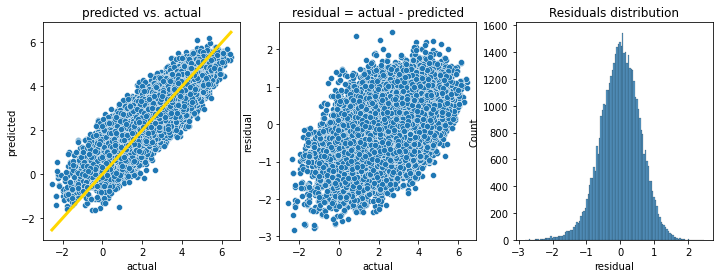

In [22]:
visualise_fit(y, y_pred)

Visual representation of the model's fit to the **unseen test set**.

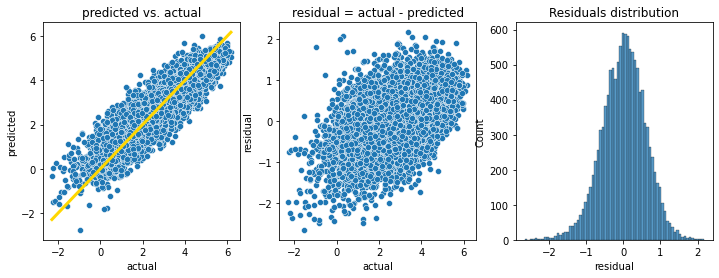

In [23]:
visualise_fit(y_test, y_test_pred)

In both the training and test set fits, the residual distributions (shown in the histograms on the right) exhibit distributions that closely resemble normality. However, upon closer examination of the **residual versus actual value plot**, a **noticeable pattern** emerges in both cases. It is evident that the **independent variables fail to capture the entire deterministic component**. The problem of **underfitting** can be addressed by engineering additional features and integrating them into the model.

### 2. Refined Linear Regression Model

### 2A. Introducing additional features, various transformers and scalers

As already discussed in the previous chapter, a strategy to address underfitting of the data involves **expanding the set of features through engineering**. To achieve this, we will employ several approaches proposed during the Exploratory Data Analysis (EDA), such as introducing **polynomial features, rational difference features and power transformers**. To better understand their influence on the model, they will be introduced one at a time.

#### 2A.1. Polynomial features ####

We'll begin by incorporating only the polynomial features into the model. They will be introduced in a simple pipeline below.

In [24]:
steps = list()
steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
steps.append(('model', lr_model))
pipeline = Pipeline(steps=steps)

During the exploratory data analysis, it was evident that certain data would benefit from fitting with a **second-degree polynomial**, while others would benefit from a **third-degree polynomial**. Now, let's **fine-tune this parameter using GridSearchCV**.

In [25]:
parameters = {
    'poly__degree': [2, 3]
} 

In [26]:
grid_poly = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True).fit(X[original_features], y)

Let's examine the outcomes of the optimization.

In [27]:
# the best parameters
grid_poly.best_params_

{'poly__degree': 3}

In [28]:
# summary of the GridSearchCV
results_poly = pd.DataFrame(grid_poly.cv_results_)
results_poly

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_MSE,split1_test_MSE,split2_test_MSE,split3_test_MSE,...,split2_train_R-squared,split3_train_R-squared,split4_train_R-squared,split5_train_R-squared,split6_train_R-squared,split7_train_R-squared,split8_train_R-squared,split9_train_R-squared,mean_train_R-squared,std_train_R-squared
0,3.620647,1.706340,0.048345,0.032682,2,{'poly__degree': 2},-0.240480,-0.257779,-0.248231,-0.248749,...,0.840885,0.840493,0.840805,0.841441,0.841174,0.840318,0.840638,0.839858,0.840675,0.000528
1,12.956104,0.523505,0.172984,0.081039,3,{'poly__degree': 3},-0.208944,-0.226766,-0.213193,-0.218069,...,0.866211,0.866125,0.866383,0.866904,0.866191,0.866052,0.865901,0.865364,0.866115,0.000433


Both second-grade and third-grade polynomial features **noticeably enhance the model's performance**. Nevertheless, it's evident that the **third-degree polynomial yields superior results**.

In [29]:
# get the performance of the model (the interesting results are in the row 1)
get_best_scores(grid_poly, 1)

# print the information about the performance
print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.8661 (0.0004)
Test set R2 score: 0.8608 (0.0046)

Training set MSE score: -0.2078 (0.0004)
Test set MSE score: -0.2158 (0.0052)


To **assess the model's performance on entirely unseen data**, we will train the model using the complete training-validation dataset and make predictions for the target values.

In [30]:
# fit the the best pipeline on the whole training-validation set
best_pipe_poly = grid_poly.best_estimator_
best_pipe_poly.fit(X[original_features], y)

# predict the target values for both the training-validation and test sets
y_pred = best_pipe_poly.predict(X[original_features])
y_test_pred = best_pipe_poly.predict(X_test[original_features])

Now, we can present the **metrics** for both the **complete training-validation set and the unseen test set**.

In [31]:
# calculate adjusted-R2 and MSE scores
get_test_scores(y, y_pred, y_test, y_test_pred, X[original_features])

# display the above scores
print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.8659)
Test set adjusted R2 score: 0.8650)

Training set MSE score: -0.2081)
Test set MSE score: -0.2151)


The comparison with the regular R-squared (R²) reveals a **slightly higher**, but still **comparable**, value for the **adjusted R-squared** (adjusted R²). Adjusted R² calculates a correction based on both the **number of features and the number of samples**, which makes the **results more comparable** between models containing different numbers of features.


The uncertainty of the scores is estimated only during GridSearchCV. However, we assume that the uncertainties of the values obtained for the unseen test data (cell above) are of a similar order of magnitude.

On one hand, the metric's value for the unseen data is less accurate because it's a single value, in contrast to an average of 10 measurements as in GridSearchCV. On the other hand, the model used to obtain the target values for the unseen test data was trained on a slightly larger dataset. Additionally, the unseen test set itself is approximately twice as large as the test sets used in GridSearchCV.

Now, let's integrate the scores of the model with additional, polynomial features into the dataframe.

In [32]:
add_scores('polynomial')

In [33]:
LM_scores.loc[('Test', 'Adjusted R2')]

baseline      0.779254
polynomial    0.864964
Name: (Test, Adjusted R2), dtype: float64

A brief comparison between the adjusted R-squared values of the baseline and polynomial models reveals a **noteworthy improvement** in this metric **upon the incorporation of polynomial features**.

#### 2A.2. Rational difference features ####

For now, let's set aside the polynomial features and focus solely on incorporating the features referred to as _rational differences_.  The motivation behind engineering features of this nature is rooted in the common observation that **models often struggle to synthesize expressions of this type effectively** <font color='gray'>_(J. Heaton, "An empirical analysis of feature engineering for predictive modeling," SoutheastCon 2016, Norfolk, VA, USA, 2016, pp. 1-6, doi: 10.1109/SECON.2016.7506650)_</font>.

Rational differences refer to equations written in this form:

$$\frac{a-b}{c}$$

Let's assess the impact of including these features on the performance of the linear model...

In [34]:
grid_diff = GridSearchCV(lr_model, param_grid={}, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True).fit(X, y)

... and display the results

In [35]:
# get the performance of the model (the interesting results are in the only row)
get_best_scores(grid_diff, 0)

# print the information about the performance
print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.8300 (0.0004)
Test set R2 score: 0.8277 (0.0064)

Training set MSE score: -0.2638 (0.0004)
Test set MSE score: -0.2671 (0.0060)


To **assess the model's performance on entirely unseen data**, we will train the model using the complete training-validation dataset and make predictions for the target values.

In [36]:
# fit the the best pipeline on the whole training-validation set
best_pipe_diff = grid_diff.best_estimator_
best_pipe_diff.fit(X, y)

# predict the target values for both the training-validation and test sets
y_pred = best_pipe_diff.predict(X)
y_test_pred = best_pipe_diff.predict(X_test)

The **metrics** for both the **complete training-validation set and the unseen test set** are following:

In [37]:
# calculate adjusted-R2 and MSE scores
get_test_scores(y, y_pred, y_test, y_test_pred, X)

# display the above scores
print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.8294)
Test set adjusted R2 score: 0.8259)

Training set MSE score: -0.2639)
Test set MSE score: -0.2742)


Let's contrast these values with those from the previous models.

In [38]:
add_scores('rational_diff')

In [39]:
LM_scores.loc[('Test', 'Adjusted R2')]

baseline         0.779254
polynomial       0.864964
rational_diff    0.825938
Name: (Test, Adjusted R2), dtype: float64

Noticeable improvement in model performance is evident when incorporating rational difference features. However, in the case of the linear regression model, the improvement is not as substantial as when including polynomial features.

#### 2A.3. Additional features and scalers

Finally, we'll construct a model that considers both polynomial and rational difference features, as well as power transformers and scalers, which were suggested during Exploratory Data Analysis and aim to enhance the model's performance.

In [40]:
# transformer applying PolynomialFeatures and PowerTransformer to 13 original features
transformers = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), original_features),
        ('power', PowerTransformer(), original_features)
    ],
    remainder='passthrough'
)

In [41]:
# make a pipeline that includes the aforementioned transformers, scalers, and the linear model
steps = list()
steps.append(('transformers', transformers))
steps.append(('scale', StandardScaler()))
steps.append(('model', lr_model))
pipeline = Pipeline(steps=steps)

The parameters that require tuning include the polynomial degree and the choice of scaler. Based on the observations made during exploratory data analysis, we will use both **StandardScaler and RobustScaler**, with the latter being more robust to outliers.

In [42]:
parameters = {
    'transformers__poly__degree': [2, 3],
    'scale': [StandardScaler(), RobustScaler()]
} 

Let's optimize the model...

In [43]:
grid_features_scalers = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True).fit(X, y)

... and have a look at the results of the optimization.

In [44]:
# the best parameters
grid_features_scalers.best_params_

{'scale': StandardScaler(), 'transformers__poly__degree': 3}

In [45]:
# summary of the GridSearchCV
results_features_scalers = pd.DataFrame(grid_features_scalers.cv_results_)
results_features_scalers[['param_scale','param_transformers__poly__degree','mean_test_R-squared', 'std_test_R-squared']]

,param_scale,param_transformers__poly__degree,mean_test_R-squared,std_test_R-squared
0,StandardScaler(),2,0.849934,0.005508
1,StandardScaler(),3,0.861967,0.004884
2,RobustScaler(),2,0.849934,0.005508
3,RobustScaler(),3,0.861967,0.004884


From the above, we can observe that there is **no statistically significant difference** between the results obtained with **StandardScaler** and **RobustScaler**.


Let's examine the metrics that characterize this model.

In [46]:
# get the performance of the model (the interesting results are in the row 1)
get_best_scores(grid_features_scalers, 1)

# print the information about the performance
print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.8688 (0.0004)
Test set R2 score: 0.8620 (0.0049)

Training set MSE score: -0.2036 (0.0004)
Test set MSE score: -0.2140 (0.0062)


To **assess the model's performance on entirely unseen data**, we will train the model using the complete training-validation dataset and make predictions for the target values.

In [47]:
# fit the the best pipeline on the whole training-validation set
best_pipe_features_scalers = grid_features_scalers.best_estimator_
best_pipe_features_scalers.fit(X, y)

# predict the target values for both the training-validation and test sets
y_pred = best_pipe_features_scalers.predict(X)
y_test_pred = best_pipe_features_scalers.predict(X_test)

The **metrics** for both the **complete training-validation set and the unseen test set** are following:

In [48]:
# calculate adjusted-R2 and MSE scores
get_test_scores(y, y_pred, y_test, y_test_pred, X)

# display the above scores
print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.8681)
Test set adjusted R2 score: 0.8655)

Training set MSE score: -0.2040)
Test set MSE score: -0.2118)


Let's provide an overview of all the models we've developed thus far.

In [49]:
add_scores('all_features')

In [50]:
LM_scores.loc[LM_scores.index.get_level_values(1) == 'Adjusted R2']

,,baseline,polynomial,rational_diff,all_features
Set,Scoring,,,,
Train,Adjusted R2,0.776504,0.865858,0.829393,0.868142
Test,Adjusted R2,0.779254,0.864964,0.825938,0.865529


The introduction of additional features and scaling existing ones had minimal impact on score improvement compared to the model with polynomial features alone. However, a slightly more noticeable enhancement in performance is observable in the training set compared to the test set. This suggests a potential issue with **overfitting**, which we will address in the upcoming section.


Now, let's evaluate the model's quality visually.

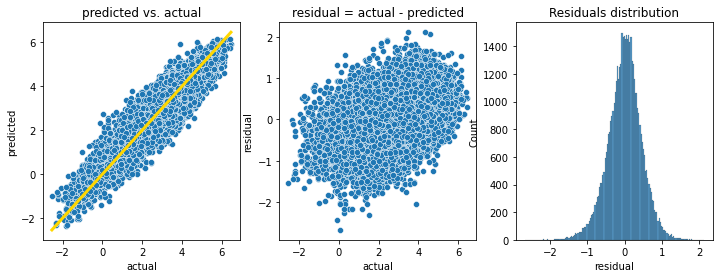

In [51]:
visualise_fit(y, y_pred)

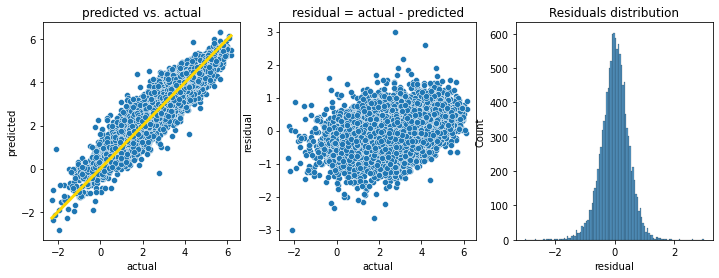

In [52]:
visualise_fit(y_test, y_test_pred)

Compared to the initial baseline model, this model exhibits a better fit to the data. However, in the middle panels, a **clear trend is still visible**, indicating that the independent variables are unable to fully capture the entire deterministic component. We hope to address and improve this limitation by applying more advanced models, such as random forests or neural networks.

### B. Enhancing Model Generalization

To enhance the model's ability to generalize to unseen data, several strategies can be implemented. Given the substantial size of the dataset, there's no necessity to augment it further. Nevertheless, we can consider incorporating regularization techniques and refining feature selection processes to potentially optimize the model's performance.

#### B1. Regularization ####

To enhance the model's ability to generalize to new data, we'll leverage regularization methods such as L1 (Lasso) or L2 (Ridge). These methods serve to penalize overly complex models, encouraging a more generalized outcome. In this context, we'll implement elastic net regularization, offering the convenience of choosing between Lasso and Ridge regularization easily.

In [53]:
from sklearn.linear_model import ElasticNet

# create an Elastic Net regression model with regularization strengths (alpha and l1_ratio)
alpha = 1.0  # initial value of alpha
l1_ratio = 0.5  # initial value of l1 to l2 ratio
elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)

In [54]:
# replace the linear model in the pipeline with elastic net
steps.pop(-1)
steps.append(('model', elastic_net_model))
pipeline = Pipeline(steps=steps)

Let's establish the parameter range for optimization. Alpha is a hyperparameter that regulates the extent of regularization applied to a model. When alpha equals 0, it implies no regularization. Lower alpha values result in less aggressive shrinking of coefficients, while higher alpha values help prevent overfitting by discouraging the model from relying too heavily on individual features.


The term "l1_ratio" denotes the mixing parameter determining the balance between L1 (Lasso) and L2 (Ridge) penalties in Elastic Net. A "l1_ratio" of 0 makes Elastic Net equivalent to Ridge regression, and a "l1_ratio" of 1 makes it equivalent to Lasso regression.

In [417]:
parameters = {
    'transformers__poly__degree': [3], # let's keep it at the optpimized value
    'scale': [StandardScaler()], # let's keep it at the optpimized value
    'model__alpha': [0.01, 0.1, 1, 10], # with alpha=0, this algorithm does not converge welw
    'model__l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]
} 

Time to optimize the model...

In [ ]:
grid_reg = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True).fit(X, y)

In [ ]:
#joblib.dump(grid_reg, 'grid_reg_results.joblib')

In [56]:
grid_reg = joblib.load('grid_reg_results.joblib')

... and have a look at the results of the optimization.

In [57]:
# the best parameters
grid_reg.best_params_

{'model__alpha': 0.01,
 'model__l1_ratio': 0,
 'scale': StandardScaler(),
 'transformers__poly__degree': 3}

In [58]:
# summary of the GridSearchCV
results_reg = pd.DataFrame(grid_reg.cv_results_)

In [59]:
# get the performance of the model (the interesting results are in the row 0)
get_best_scores(grid_reg, 0)

# print the information about the performance
print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.8419 (0.0005)
Test set R2 score: 0.8402 (0.0043)

Training set MSE score: -0.2454 (0.0005)
Test set MSE score: -0.2478 (0.0043)


The presented results highlight optimal performance when only a small amount of regularization is applied. To gain a deeper understanding of these results, let's visualize the model's performance across the various parameter combinations.

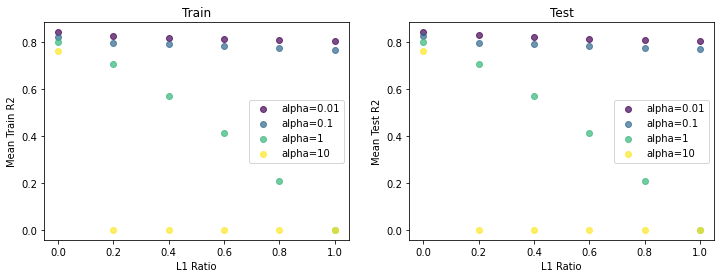

In [418]:
alpha_values = parameters['model__alpha']

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# function to get a color based on alpha index
def get_color(alpha_index):
    cmap = plt.get_cmap('viridis') 
    return cmap(alpha_index / (len(alpha_values) - 1))

# filter and plot the results based on alpha values
for alpha_index, alpha in enumerate(alpha_values):
    results_filtered = results_reg[results_reg['param_model__alpha'] == alpha]
    color = get_color(alpha_index)
    
    ax1.scatter(results_filtered['param_model__l1_ratio'], results_filtered['mean_train_R-squared'],
                marker='o', color=color, alpha=0.7, label=f'alpha={alpha}')

    ax2.scatter(results_filtered['param_model__l1_ratio'], results_filtered['mean_test_R-squared'],
                marker='o', color=color, alpha=0.7, label=f'alpha={alpha}')

ax1.legend()
ax2.legend()

# Set labels and titles
ax1.set_xlabel('L1 Ratio')
ax1.set_ylabel('Mean Train R2')
ax2.set_xlabel('L1 Ratio')
ax2.set_ylabel('Mean Test R2')

ax1.set_title('Train')
ax2.set_title('Test')

plt.show()

The model demonstrates **optimal performance** when the **alpha parameter is set to its lowest tested value** (alpha=0.01), gradually deteriorating as alpha increases, eventually leading to random predictions at alpha=10. Another noteworthy trend is that whenever regularization is implemented, the **model tends to achieve higher scores with Ridge regularization compared to Lasso regularization**.

To **assess the model's performance on entirely unseen data**, we will train the best model using the complete training-validation dataset and make predictions for the target values.

In [61]:
# fit the the best pipeline on the whole training-validation set
best_pipe_reg = grid_reg.best_estimator_
best_pipe_reg.fit(X, y)

# predict the target values for both the training-validation and test sets
y_pred = best_pipe_reg.predict(X)
y_test_pred = best_pipe_reg.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6385.721357526648, tolerance: 7.618462662246744
  model = cd_fast.enet_coordinate_descent(


The **metrics** for both the **complete training-validation set and the unseen test set** are following:

In [62]:
# calculate adjusted-R2 and MSE scores
get_test_scores(y, y_pred, y_test, y_test_pred, X)

# display the above scores
print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.8413)
Test set adjusted R2 score: 0.8423)

Training set MSE score: -0.2455)
Test set MSE score: -0.2484)


Let's contrast the model with regularization against the previous one.

In [63]:
add_scores('regularization')

In [64]:
LM_scores.loc[LM_scores.index.get_level_values(1) == 'Adjusted R2']

,,baseline,polynomial,rational_diff,all_features,regularization
Set,Scoring,,,,,
Train,Adjusted R2,0.776504,0.865858,0.829393,0.868142,0.841287
Test,Adjusted R2,0.779254,0.864964,0.825938,0.865529,0.842315


The given parameters indicate that **any form of regularization reduces the model's performance** on both the training and test sets. This strongly implies the **absence of overfitting** in the model.

#### B2. K best ####

An alternative strategy for improving the model's performance involves selecting relevant features.

Following all feature engineering steps, the model comprises the following number of features: 

In [65]:
X_transformed = pd.DataFrame(best_pipe_features_scalers[:-1].transform(X))
n_features = X_transformed.shape[1]
n_features

708

Filter methods, such as **SelectKBest**, are a natural choice for feature selection in **models with numerous features**. Unlike wrapper methods, filter methods assess feature importance independently of the model, making them computationally efficient for large datasets. SelectKBest, utilizing statistical measures, **evaluates each feature's relevance to the target variable individually**, offering a quick and less computationally demanding way to identify informative features in high-dimensional spaces.


To increase the model's robustness lets focus on selecting the most important features.

In [68]:
steps.pop(-1)
steps.append(('kbest', SelectKBest()))
steps.append(('model', lr_model))
pipeline = Pipeline(steps=steps)

Let's assess the model's performance with the number of features ranging from 100 to the total number of features in increments of 100. Additionally, let's optimize the choice of scoring function. **_f regression_** assesses linear relationships between features and the target, using the F-statistic from ANOVA. In contrast, **_mutual_info_regression_** is more flexible, capturing both linear and non-linear relationships through mutual information.

In [69]:
parameters = {
    'transformers__poly__degree': [3],
    'scale': [StandardScaler()],
    'kbest__k': [100, 200, 300, 400, 500, 600, 700, 706],
    'kbest__score_func': [f_regression, mutual_info_regression]
} 

In [ ]:
grid_kbest = GridSearchCV(pipeline, parameters, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE', return_train_score=True).fit(X, y)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_kbest, 'grid_kbest_result.joblib')

In [70]:
# load the results
grid_kbest = joblib.load('grid_kbest_result.joblib')

The optimal results are as follows:

In [71]:
# the best parameters
grid_kbest.best_params_

{'kbest__k': 700,
 'kbest__score_func': <function sklearn.feature_selection._mutual_info.mutual_info_regression(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>,
 'scale': StandardScaler(),
 'transformers__poly__degree': 3}

In [72]:
# summary of the GridSearchCV
results_kbest = pd.DataFrame(grid_kbest.cv_results_)

In [73]:
# get the performance of the model (the interesting results are in the row 13)
get_best_scores(grid_kbest, 13)

# print the information about the performance
print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.8686 (0.0004)
Test set R2 score: 0.8626 (0.0045)

Training set MSE score: -0.2039 (0.0004)
Test set MSE score: -0.2131 (0.0052)


Let's create visualizations to better grasp how the **model's performance evolves with different numbers of features and the chosen scoring function**.

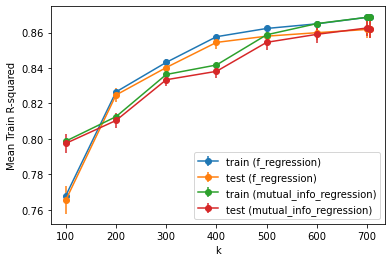

In [74]:
# turn functions into strings
results_kbest['param_kbest__score_func'] = results_kbest['param_kbest__score_func'].astype(str)
# get the feature selection function name
results_kbest['param_kbest__score_func'] = results_kbest['param_kbest__score_func'].str.split().str[1]
# group the results by the feature selection function name
grouped_results = results_kbest.groupby('param_kbest__score_func')

# Plot each group separately
for name, group in grouped_results:
    plt.errorbar(group['param_kbest__k'], group['mean_train_R-squared'], yerr=group['std_train_R-squared'], marker='o', label=f'train ({name})')
    plt.errorbar(group['param_kbest__k'], group['mean_test_R-squared'], yerr=group['std_test_R-squared'], marker='o', label=f'test ({name})')

# Display legends and labels
plt.legend()
plt.xlabel('k')  # Label for the x-axis
plt.ylabel('Mean Train R-squared')  # Label for the y-axis

plt.show()


_The error bars for the training set are too small to be visible on the plot._

Regarding **_'f_regression'_**, the training set's model performance improves with more features _(blue line)_, but the test curve levels off around 600-700 features, with a slight subsequent decline (though not statistically significant) _(orange)_. This pattern implies that we may be approaching the point of overfitting.

**'Mutual_info_regression'** seems to produce better results for our model; however, it appears that there is no advantage in using a lower number of features.

Now, let's investigate the optimized model by training it on the **entire available training data**. Subsequently, we'll assess its performance on the **unseen test set**.

In [75]:
# fit the the best pipeline on the whole training-validation set
best_pipe_kbest = grid_kbest.best_estimator_
best_pipe_kbest.fit(X, y)

# predict the target values for both the training-validation and test sets
y_pred = best_pipe_kbest.predict(X)
y_test_pred = best_pipe_kbest.predict(X_test)

The **metrics** for both the **complete training-validation set and the unseen test set** are following:

In [76]:
# calculate adjusted-R2 and MSE scores
get_test_scores(y, y_pred, y_test, y_test_pred, X)

# display the above scores
print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.8679)
Test set adjusted R2 score: 0.8653)

Training set MSE score: -0.2043)
Test set MSE score: -0.2122)


Let's incorporate the scores for comparison; nevertheless, it is evident that the utilization of SelectKBest does not provide any enhancement.

In [77]:
add_scores('kbest')

We observe **no statistically significant distinction between the model utilizing all features and the model employing SelectKBest**. This can be attributed to the presence of highly correlated features. SelectKBest, rather than discarding features that duplicate information, may exclude potentially valuable features that exhibit lower correlation with the target.

Although these outcomes do not exhibit improvement, more promising results might be achievable with advanced feature selection methods. Recursive Feature Elimination (RFE) can be advantageous when SelectKBest offers limited improvements, systematically eliminating the least relevant features while considering the interdependence between them.

#### b3. RFE ####

Recursive Feature Elimination (RFE) is a feature selection technique that systematically removes the least important features from the model. It iteratively fits the model and evaluates feature importance, eliminating the least significant features in each iteration. This process continues until the desired number of features is reached. 

Let's incorporate the Recursive Feature Elimination (RFE) method into the model.

In [197]:
# replace SelectKBest with Recursive Feature Elimination
steps.pop(-2)
rfe = RFE(estimator=LinearRegression(), n_features_to_select='all')
steps.insert(-1,('rfe', rfe))
pipeline = Pipeline(steps=steps)

Let's investigate the model's performance using the same range of parameters as with SelectKBest.

In [198]:
parameters = {
    'transformers__poly__degree': [3],
    'scale': [StandardScaler()],
    'rfe__n_features_to_select': [100, 200, 300, 400, 500, 600, 700, 706]
} 

In [ ]:
grid_rfe = GridSearchCV(pipeline, parameters, cv=cv, scoring=scoring, refit='MSE', return_train_score=True).fit(X, y)

In [ ]:
# save the GridSearchCV results
joblib.dump(grid_rfe, 'grid_rfe_result.joblib')

In [199]:
# load the results
grid_rfe = joblib.load('grid_rfe_result.joblib')

The optimal results are following:

In [200]:
# the best parameters
grid_rfe.best_params_

{'rfe__n_features_to_select': 600,
 'scale': StandardScaler(),
 'transformers__poly__degree': 3}

In [201]:
# summary of the GridSearchCV
results_rfe = pd.DataFrame(grid_rfe.cv_results_)

In [202]:
# get the performance of the model (the interesting results are in the row 5)
get_best_scores(grid_kbest, 5)

# print the information about the performance
print_CV_scores()

Results obtained from GridSearchCV on the training-validation set:

Training set R2 score: 0.8363 (0.0004)
Test set R2 score: 0.8334 (0.0037)

Training set MSE score: -0.2540 (0.0004)
Test set MSE score: -0.2584 (0.0041)


The results reveal that, **with RFE, optimal performance can be achieved with fewer features** than with SelectKBest. Let's visually compare the model's performance as the number of features changes for RFE and KBest.

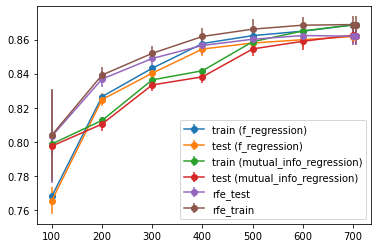

In [203]:
# Plot each group separately
for name, group in grouped_results:
    plt.errorbar(group['param_kbest__k'], group['mean_train_R-squared'], yerr=group['std_train_R-squared'], marker='o', label=f'train ({name})')
    plt.errorbar(group['param_kbest__k'], group['mean_test_R-squared'], yerr=group['std_test_R-squared'], marker='o', label=f'test ({name})')

#plt.errorbar(results_kbest['param_kbest__k'], results_kbest['mean_test_R-squared'], yerr=results_kbest['std_test_R-squared'], marker='o', label='kbest_test')
#plt.errorbar(results_kbest['param_kbest__k'], results_kbest['mean_train_R-squared'], yerr=results_kbest['std_test_R-squared'], marker='o', label='kbest_train')
plt.errorbar(results_rfe['param_rfe__n_features_to_select'], results_rfe['mean_test_R-squared'], yerr=results_rfe['std_test_R-squared'], marker='o', label='rfe_test')
plt.errorbar(results_rfe['param_rfe__n_features_to_select'], results_rfe['mean_train_R-squared'], yerr=results_rfe['std_test_R-squared'], marker='o', label='rfe_train')
plt.legend()
plt.show()

Above, it's evident that **RFE outperforms KBest** across a diverse range of feature counts.

Now, let's assess the **model's performance using the best 600 features** selected with RFE, trained on the entire training dataset.

In [207]:
# fit the the best pipeline on the whole training-validation set
best_pipe_rfe = grid_rfe.best_estimator_
best_pipe_rfe.fit(X, y)

# predict the target values for both the training-validation and test sets
y_pred = best_pipe_rfe.predict(X)
y_test_pred = best_pipe_rfe.predict(X_test)

The **metrics** for both the **complete training-validation set and the unseen test set** are following:

In [208]:
# calculate adjusted-R2 and MSE scores
get_test_scores(y, y_pred, y_test, y_test_pred, X)

# display the above scores
print_test_scores()

Results obtained from the training-validation and the unseen test set:

Training set adjusted R2 score: 0.8678)
Test set adjusted R2 score: 0.8659)

Training set MSE score: -0.2045)
Test set MSE score: -0.2113)


Let's assess the **performance of this model in comparison to the previous ones**. Given the notable disparity in the number of features among the models we are specifically interested in ('all_features', 'kbest', 'rfe'), we'll focus on comparing the Adjusted R2 scores.

In [209]:
add_scores('rfe')

In [210]:
LM_scores.loc[LM_scores.index.get_level_values(1) == 'Adjusted R2']

,,baseline,polynomial,rational_diff,all_features,regularization,kbest,rfe
Set,Scoring,,,,,,,
Train,Adjusted R2,0.776504,0.865858,0.829393,0.868142,0.841287,0.867944,0.867842
Test,Adjusted R2,0.779254,0.864964,0.825938,0.865529,0.842315,0.865321,0.865879


Text(0, 0.5, 'Test R-squared')

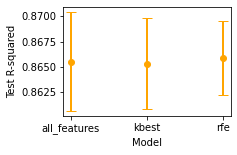

In [273]:
# compare model with all features with model with selected k best features
columns = ['all_features', 'kbest', 'rfe']

# select R2 scores with std of the test set
df = LM_scores[columns].loc[(LM_scores.index.get_level_values(0) == 'Test') & (LM_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))]
df = df.droplevel(0).T

# plot data with std
plt.figure(figsize=(3, 2))
plt.errorbar(x=df.index, y=df['Adjusted R2'], yerr=df['CV_R2_std'], fmt='o', color='orange', capsize=5, elinewidth=2)
plt.xlabel('Model')
plt.ylabel('Test R-squared')

While the analysis of the parameters presented above doesn't reveal any statistically significant improvement in the model's performance, **the plot (located a few cells above) comparing SelectKBest with RFE** across a wide spectrum of feature counts suggests that **RFE yields superior results**. Consequently, we will adopt the RFE model as our final choice.

Let's visualize the model fit.

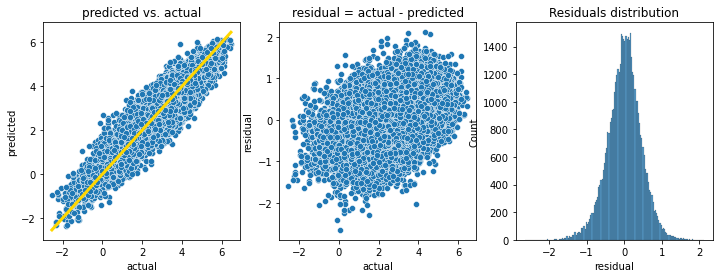

In [213]:
visualise_fit(y, y_pred)

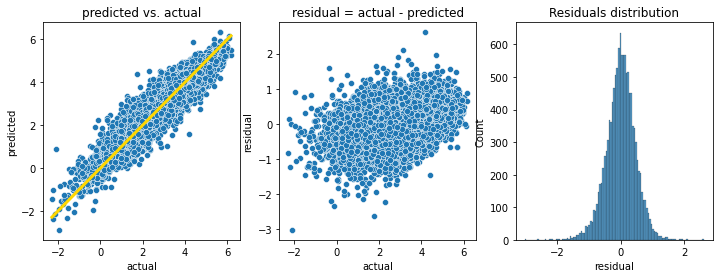

In [214]:
visualise_fit(y_test, y_test_pred)

While the current model is an improvement over the initial one and marginally better than the model before feature selection, there is still a noticeable trend in residuals. The independent variables fall short of capturing the complete deterministic component, suggesting the need for more complex models beyond linear regression.

### 3. Summary

Let's assess the progression of the model by examining different metrics at key stages, including feature engineering, model optimization, and feature selection. For this purpose, I have chosen Adjusted R2 as it facilitates the comparison of models with varying numbers of features. Given the fairly strong agreement between Adjusted R2 and R2 values, we'll utilize the standard deviation obtained from GridSearchCV to illustrate the estimated range of uncertainties. This approach will aid us in effectively comparing the models.

In [385]:
# select Adjusted R2 values together with std values
metrics_test = LM_scores.loc[(LM_scores.index.get_level_values(0) == 'Test')&(LM_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))].droplevel(0).T
metrics_test['Set'] = 'Test'
metrics_train = LM_scores.loc[(LM_scores.index.get_level_values(0) == 'Train')&(LM_scores.index.get_level_values(1).isin(['Adjusted R2', 'CV_R2_std']))].droplevel(0).T
metrics_train['Set'] = 'Train'
metrics = pd.concat([metrics_train, metrics_test])

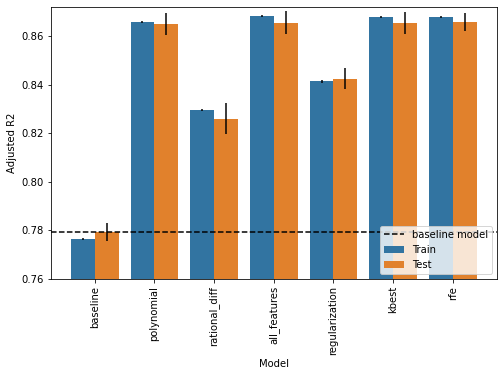

In [414]:
# set the figure size
plt.figure(figsize=(8, 5))

# create a bar plot, calculate x and y coordinates for error bars and add errror bars
ax = sns.barplot(data=metrics, x=metrics.index, y='Adjusted R2', hue='Set')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=metrics['CV_R2_std'], fmt="none", c="k")

# Add a horizontal line at a specific y-value (adjust the y-value as needed)
ax.axhline(y=metrics.loc['baseline', 'Adjusted R2'].values[1], color='black', linestyle='--', label='baseline model')

# add labels, set limits and ticks
plt.xlabel('Model')  
plt.ylabel('Adjusted R2') 
plt.ylim(0.76, 0.872)
plt.xticks(rotation=90)
plt.legend()
plt.legend(loc='lower right')

# Show the plot
plt.show()

In the analysis above, it's evident that the **inclusion of engineered features has notably enhanced the model's performance**. Specifically, for the linear regression model, the most substantial improvement arises from the introduction of **polynomial features**. Once these polynomial features are integrated into the model, the subsequent addition of rational difference features doesn't yield a statistically significant improvement.


In the previous section, a visual comparison between features selected using SelectKBest and Recursive Feature Elimination (RFE) demonstrated the superiority of the latter method. Therefore, RFE was adopted for the final Linear Regression model.

In [415]:
# save Linear Regression's metrics for further comparison
LM_scores.to_csv('LM_scores.csv', index=False)